#Download data

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gregoralt","key":"25d6db12987472f28f8035583be68b72"}'}

#API Processing

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#Change permission
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c titanic

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df=pd.read_csv('/content/train.csv')
df=df.set_index('PassengerId')

#Feature Engineering
- The cabin seems that it was a factor that helped in order for you to survive
- Given the fare you payed, the cabin was assigned
-If you went with your family onto the Titanic there was a big probability you would survive


In [ ]:
#Things to do: 
#Recover null values on age with mean value, replace gender with numerical values

df['Cabin']=df['Cabin'].replace(np.nan,'N') 
m=df['Age'].mean()
df['Age']=df['Age'].replace(np.nan,m)
df['Age']=df['Age'].round(0) #Round age mean numbers
df['Sex']=df['Sex'].replace({'male':0,'female':1})
df['Sex'].unique()
df['Cabin']=df['Cabin'].str[0]#Get only the letter of the cabin to create categories of it
df.groupby('Cabin')['Fare'].describe()

,count,mean,std,min,25%,50%,75%,max
Cabin,,,,,,,,
A,15.0,39.623887,17.975333,0.0000,30.8479,35.50000,50.24790,81.8583
B,47.0,113.505764,109.301500,0.0000,57.0000,80.00000,120.00000,512.3292
C,59.0,100.151341,70.225588,26.5500,42.5021,83.47500,143.59165,263.0000
D,33.0,57.244576,29.592832,12.8750,30.0000,53.10000,77.28750,113.2750
E,32.0,46.026694,32.608315,8.0500,26.1125,45.18125,56.15730,134.5000
F,13.0,18.696792,11.728217,7.6500,7.7500,13.00000,26.00000,39.0000
G,4.0,13.581250,3.601222,10.4625,10.4625,13.58125,16.70000,16.7000
N,687.0,19.157325,28.663343,0.0000,7.8771,10.50000,23.00000,512.3292
T,1.0,35.500000,NaN,35.5000,35.5000,35.50000,35.50000,35.5000


In [ ]:
df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Adding the cabin feature we could try to get another variable into the algorithm and a more precise prediction of the survival rate of the passengers.

In [ ]:
#Given the fare, the cabin was assigned
#Cabin Classification of NaN values
def repl_N(val):
    n = 0
    if val==35:
        n = 'T'
    elif val<=14:
        n = 'G'
    elif 14<val<=26:
        n='F'
    elif 26<val<=39:
        n='A'
    elif 39<val<=53:
        n='E'
    elif 53<val<=80:
        n='D'
    elif 80<val<=115:
        n='C'
    else:
        n='B'
    return n
df['Cabin']=df['Fare'].apply(repl_N)
df['Cabin'].value_counts()

G    437
F    159
A    109
D     72
B     42
E     39
C     32
T      1
Name: Cabin, dtype: int64

If someone has a parent, children (parch) sibling, or spouse (sibsp) it can be infered that they had family, which makes it more likely to survive.

In [ ]:
#Family feature engineering
df['Family']=np.where(df['SibSp']!=0,1,np.where(df['Parch']!=0,1,0))
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,G,S,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,D,C,1
3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,G,S,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,D,S,1
5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,G,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.0000,G,S,0
888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,A,S,0
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,29.7,1,2,W./C. 6607,23.4500,F,S,1


#Graphs

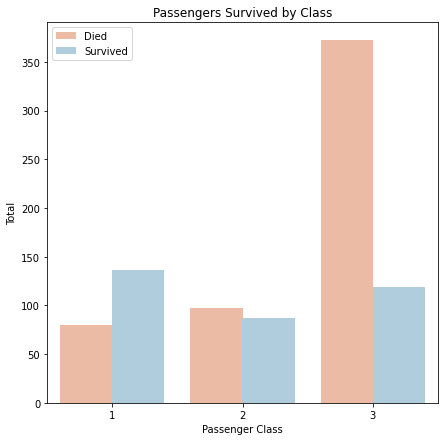

In [ ]:
fig1, ax = plt.subplots(figsize=(7,7))
ax=sns.countplot(x=df['Pclass'],hue=df['Survived'],palette='RdBu')
ax.set(title='Passengers Survived by Class',xlabel='Passenger Class',ylabel='Total')
ax.legend(labels=['Died','Survived'])
plt.show()

#Tool Import Scikit-Learn
The approach to train our model was:
## On the Preprocessing
1. The city was Label Encoded as well as the Gender
2. Data was Scaled with a Pipeline 
3. A parameter space was created for each ML model 

## On the Model Construction
1. Have a Logistic Regression as a baseline model 
2. Create a Decision Tree
3. Random Forest Classifier
4. Added some booster models
5. Every model had a Grid Search CV to ensure the parameters were tuned at its finest 
6. Compile all models on a Voting Classifier with a Hard method

In [ ]:
#Import tools from scikitlearn
from sklearn import tree 
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold,RandomizedSearchCV,train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline



#Data Preprocessing

In [ ]:
#Decide the Variables That are going to be used
df=df.drop(columns=['Name','SibSp','Parch','Ticket'])
df.head()


,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Family
PassengerId,,,,,,,,
1,0,3,0,22.0,7.2500,G,S,1
2,1,1,1,38.0,71.2833,D,C,1
3,1,3,1,26.0,7.9250,G,S,0
4,1,1,1,35.0,53.1000,D,S,1
5,0,3,0,35.0,8.0500,G,S,0


In [ ]:
le=LabelEncoder()
df['Embarked_Encode']=le.fit_transform(df['Embarked'].astype(str))
df['Cabin_Encode']=le.fit_transform(df['Cabin'].astype(str))

In [ ]:
df=df.drop(columns=['Cabin','Embarked'],axis=1)
df

,Pclass,Sex,Age,Fare,Family,Embarked_Encode,Cabin_Encode
PassengerId,,,,,,,
1,3,0,22.0,7.2500,1,2,6
2,1,1,38.0,71.2833,1,0,3
3,3,1,26.0,7.9250,0,2,6
4,1,1,35.0,53.1000,1,2,3
5,3,0,35.0,8.0500,0,2,6
...,...,...,...,...,...,...,...
887,2,0,27.0,13.0000,0,2,6
888,1,1,19.0,30.0000,0,2,0
889,3,1,29.7,23.4500,1,2,5


In [ ]:
outcome=df['Survived']
df=df.drop(columns=['Survived'])
print(len(outcome))
print(len(df))
X=df  
y=outcome

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


#Logistic Regression

In [ ]:
#Scaling with a pipeline
X=df
y=outcome
lr=LogisticRegression()
steps=[('scaler',StandardScaler()),('logistic_regression',lr)]
pipeline=Pipeline(steps)
lr_scaled=pipeline.fit(X,y)

In [ ]:
lr=LogisticRegression(random_state=32,solver='liblinear')
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)
# Create grid search using 5-fold cross validation
clf = GridSearchCV(lr, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X_train, y_train)
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])


Best Penalty: l1
Best C: 1.0


In [ ]:
clf.score(X_train,y_train)

0.7907303370786517

In [ ]:
cv=StratifiedShuffleSplit(n_splits=20,test_size=0.3,random_state=0)
cross_v_score= cross_val_score(LogisticRegression(max_iter=10000000),X,y,cv=cv)
print(cross_v_score)
print('mean cross validation score:{0:2.2f}'.format(np.mean(cross_v_score)))

[0.81343284 0.79850746 0.79477612 0.77985075 0.79477612 0.82462687
 0.8358209  0.77238806 0.76119403 0.76492537 0.78731343 0.79477612
 0.79477612 0.7761194  0.81716418 0.77985075 0.80223881 0.79850746
 0.79104478 0.81343284]
mean cross validation score:0.79


In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

c = list(np.linspace(0.01,10,19))
penalties = ['l1','l2']
cv = StratifiedShuffleSplit(n_splits = 10, test_size = .3)
param = {'penalty': penalties, 'C': c}
logreg = LogisticRegression(solver='liblinear')
grid = RandomizedSearchCV(estimator=LogisticRegression(), 
                           param_distributions = param,
                           scoring = 'accuracy',
                           cv = cv,n_iter=40
                          )
## Fitting the model
grid.fit(X, y)

In [ ]:
print(grid.best_estimator_)
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_index_)

LogisticRegression(C=0.5650000000000001, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
{'penalty': 'l2', 'C': 0.5650000000000001}
0.7917910447761194
3


In [ ]:
lr.fit(X,y)
lr.score(X,y)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.7912457912457912

#Decision Tree

In [ ]:
import random
#Create Parameter Grid
param_dist = {"max_depth": [3, None],
              "criterion": ["gini", "entropy"]}
t=DecisionTreeClassifier()
tree_cv = RandomizedSearchCV(t, param_dist, cv=5)

tree_cv.fit(X,y)
dt=tree_cv
dt.fit(X,y)
dt.score(X,y)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


0.8215488215488216

#Random Forest Classifier

In [ ]:
n_estimators_n=[145,150]
max_depth_n=range(1,10)
criterion_n = ["gini", "entropy"]

params={'max_depth':max_depth_n,'criterion':criterion_n,'n_estimators':n_estimators_n}

grid_cv = GridSearchCV(RandomForestClassifier(), params, cv=5,scoring='neg_mean_squared_error', refit=True)
scaler=StandardScaler().fit(X)
X_scaled=scaler.transform(X)
X=X_scaled
grid_cv.fit(X,y)
final_model = grid_cv.best_estimator_


In [ ]:
rfc=grid_cv.best_estimator_
rfc.score(X,y)

0.9259259259259259

#Extra Trees Classifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
etc=ExtraTreesClassifier()
etc.fit(X,y)
etc.score(X,y)

0.9820426487093153

#Gradient Boost Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
max_depth_n=range(2,10)
params={'max_depth':max_depth_n}
grid_cv= GridSearchCV(GradientBoostingClassifier(),param_grid=params)
grid_cv.fit(X,y)

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
      

In [ ]:
gbc=grid_cv.best_estimator_
gbc.score(X,y)

0.9281705948372615

#Bagging Classifier

In [ ]:
from sklearn.ensemble import BaggingClassifier
n_estimators_n = [10,20,30,50,70,80,100,120, 140,150]
params={'n_estimators':n_estimators_n}
grid_cv= GridSearchCV(BaggingClassifier(),param_grid=params,cv=5)
grid_cv.fit(X,y)

GridSearchCV(cv=5, error_score=nan,
             estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
                                         bootstrap_features=False,
                                         max_features=1.0, max_samples=1.0,
                                         n_estimators=10, n_jobs=None,
                                         oob_score=False, random_state=None,
                                         verbose=0, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'n_estimators': [10, 20, 30, 50, 70, 80, 100, 120, 140,
                                          150]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
print(grid_cv.best_estimator_)
print(grid_cv.best_params_)
print(grid_cv.best_score_)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
{'max_depth': 4}
0.8395267089322704


In [ ]:
bc_n=grid_cv.best_estimator_
bc_n.score(X,y)

0.9809203142536476

#Ada Boost Classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
n_estimators_n = [50,70,80,100]
cv_n=5
params = {'n_estimators':n_estimators_n}
grid_cv= GridSearchCV(AdaBoostClassifier(),param_grid=params,cv=cv_n)
grid_cv.fit(X,y)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='deprecated', n_jobs=None,
             param_grid={'n_estimators': [50, 70, 80, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
abc=grid_cv.best_estimator_
abc.score(X,y)

0.8395061728395061

#Voting Classifier
This is an attempt to create three different ML models and compile a new one that learns from these three. Creating with this a much more robust information and able to predict the outcome of the dataset.

In [ ]:
from sklearn.ensemble import VotingClassifier

evc=VotingClassifier(estimators=[('lr',lr),('rfc',rfc),('dt',dt),('etc',etc),('abc',abc),('bc',bc_n,),('gbc',gbc)],voting='hard')


In [ ]:
evc.fit(X,y)
evc.score(X,y)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


0.9236812570145904

#Predict results of the DataSet Test

In [ ]:
test=pd.read_csv('test.csv')
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [ ]:
test['Cabin'].value_counts()

B57 B59 B63 B66    3
C80                2
C116               2
E34                2
C101               2
                  ..
D28                1
A18                1
C86                1
D10 D12            1
B24                1
Name: Cabin, Length: 76, dtype: int64

In [ ]:
#Preparing the test data for the ML Voting Classifier
le=LabelEncoder()
test['Embarked_Encode']=le.fit_transform(test['Embarked'].astype(str))#Hot encoding
m=test['Age'].mean()
test['Age']=test['Age'].replace(np.nan,m)
test['Age']=test['Age'].round(2)
test['Sex']=test['Sex'].replace({'male':0,'female':1})
test['Cabin']=test['Cabin'].replace(np.nan,'N')
test['Cabin']=test['Cabin'].str[0]
test.groupby('Cabin')['Fare'].describe()
test['Cabin']=test['Fare'].apply(repl_N)
test['Cabin'].value_counts()
test['Family']=np.where(test['SibSp']!=0,1,np.where(test['Parch']!=0,1,0))
test['Embarked_Encode']=le.fit_transform(test['Embarked'].astype(str))
test['Cabin_Encode']=le.fit_transform(test['Cabin'].astype(str))
test=test.drop(columns=['Embarked','Cabin'])

test=test.drop(columns=['Name','SibSp','Parch','Ticket'])
test


,PassengerId,Pclass,Sex,Age,Fare,Embarked_Encode,Family,Cabin_Encode
0,892,3,0,34.50,7.8292,1,0,6
1,893,3,1,47.00,7.0000,2,1,6
2,894,2,0,62.00,9.6875,1,0,6
3,895,3,0,27.00,8.6625,2,0,6
4,896,3,1,22.00,12.2875,2,1,6
...,...,...,...,...,...,...,...,...
413,1305,3,0,30.27,8.0500,2,0,6
414,1306,1,1,39.00,108.9000,0,0,2
415,1307,3,0,38.50,7.2500,2,0,6
416,1308,3,0,30.27,8.0500,2,0,6


In [ ]:
n=test['Fare'].mean()
test['Fare']=test['Fare'].replace(np.nan,n)
test.isna().sum()

PassengerId        0
Pclass             0
Sex                0
Age                0
Fare               0
Embarked_Encode    0
Family             0
Cabin_Encode       0
dtype: int64

In [ ]:
index=test['PassengerId']
test=test.set_index('PassengerId')
test

,Pclass,Sex,Age,Fare,Embarked_Encode,Family,Cabin_Encode
PassengerId,,,,,,,
892,3,0,34.50,7.8292,1,0,6
893,3,1,47.00,7.0000,2,1,6
894,2,0,62.00,9.6875,1,0,6
895,3,0,27.00,8.6625,2,0,6
896,3,1,22.00,12.2875,2,1,6
...,...,...,...,...,...,...,...
1305,3,0,30.27,8.0500,2,0,6
1306,1,1,39.00,108.9000,0,0,2
1307,3,0,38.50,7.2500,2,0,6


In [ ]:
scaler=StandardScaler().fit(test)
test_scales=scaler.transform(test)
test=test_scales

In [ ]:
t=(evc.predict(test))
t.tolist()
r_0=np. count_nonzero(t == 0, axis=0)
r_1=np. count_nonzero(t == 1, axis=0)
print(r_0,'   ',r_1)
print(t)


287     131
[0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 1
 1 0 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 0]


In [ ]:

test

array([[ 8.73481905e-01, -7.55928946e-01,  3.35034830e-01, ...,
        -4.70915350e-01, -8.07572853e-01,  7.49375786e-01],
       [ 8.73481905e-01,  1.32287566e+00,  1.32557226e+00, ...,
         7.00766890e-01,  1.23827837e+00,  7.49375786e-01],
       [-3.15819190e-01, -7.55928946e-01,  2.51421717e+00, ...,
        -4.70915350e-01, -8.07572853e-01,  7.49375786e-01],
       ...,
       [ 8.73481905e-01, -7.55928946e-01,  6.52006807e-01, ...,
         7.00766890e-01, -8.07572853e-01,  7.49375786e-01],
       [ 8.73481905e-01, -7.55928946e-01, -1.63035826e-04, ...,
         7.00766890e-01, -8.07572853e-01,  7.49375786e-01],
       [ 8.73481905e-01, -7.55928946e-01, -1.63035826e-04, ...,
        -1.64259759e+00,  1.23827837e+00,  2.68947751e-01]])

In [ ]:
results=pd.DataFrame({'PassengerId':index,'Survived':t})
results.PassengerId = results.PassengerId.astype(int)
results.Survived = results.Survived.astype(int)
results=results.set_index('PassengerId')
results

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


In [ ]:
results.to_csv('/content/results.csv')
from google.colab import files
files.download('results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>